# Titanic - Machine Learning from Disaster - Kaggle Competition

## Reading in the data

Importing the libraries that we will be making use of:

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Since we are using Jupyter Notebook and we would like to see plots displayed directly below the code cells that produce them, we must use the following:

In [42]:
%matplotlib inline

The data is split into training data and test data. We will be training our model on the training data. Read in the training data CSV as a Pandas dataframe:

In [43]:
titanic_train = pd.read_csv('train.csv')

In [44]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [45]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


The training data above has a column named "Survived". We will be using Logistic Regression to predict whether passengers in the test data survived or perished. Logistic regression is a technique that can be used for binary classification (in this case predicting whether or not the passenger survived).

## Data visualisation

### This section is just to explore the data and gain some preliminary insight. You can skip to the feature engineering section if you don't want to view this.

Let's look at the correlation between the 'Survived' column and other numeric columns.

In [67]:
titanic_train.corr()['Survived']

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

<br>

<AxesSubplot:xlabel='Survived', ylabel='count'>

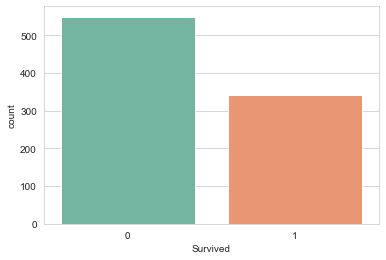

In [51]:
sns.countplot(x='Survived',data=titanic_train,palette='Set2')

How many people survived and how many perished?

<br>

More people perished than survived.

<br>

How did this differ between males and females?

<AxesSubplot:xlabel='Survived', ylabel='count'>

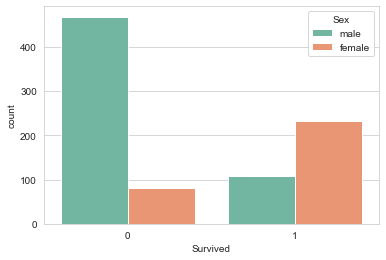

In [55]:
sns.countplot(x='Survived',data=titanic_train,hue='Sex',palette='Set2')

Passengers that perished were much more likely to be male.

<br>

Let's take a look at passenger class:

<AxesSubplot:xlabel='Survived', ylabel='count'>

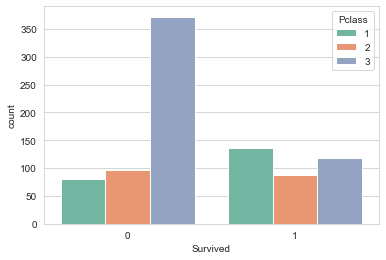

In [58]:
sns.countplot(x='Survived',data=titanic_train,hue='Pclass',palette='Set2')

The largest number of people who perished had 3rd Class tickets. However, this data is not very useful as we need to look at how many tickets of each class were sold overall.

<br>

Let's take a look at the distribution of the cost of tickets.

<AxesSubplot:>

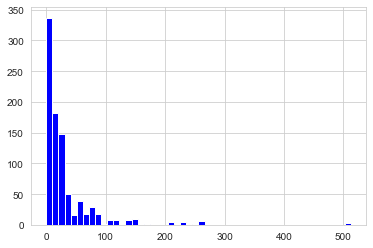

In [61]:
titanic_train['Fare'].hist(color='blue',bins=50)

Let's see if there is a link between cost of ticket and whether or not the passenger survived as we saw some correlation earlier.

<AxesSubplot:xlabel='Survived', ylabel='Fare'>

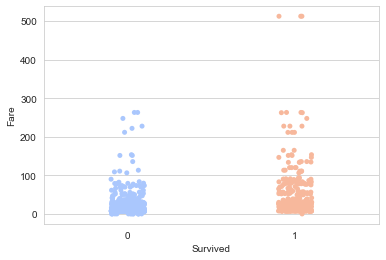

In [65]:
sns.stripplot(x="Survived", y="Fare", data=titanic_train,palette='coolwarm')

The plot above doesn't show a clear visual link.

What if we make the hue 'Sex'?

<AxesSubplot:xlabel='Survived', ylabel='Fare'>

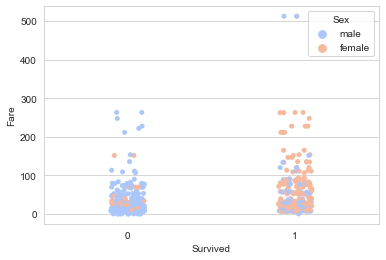

In [71]:
sns.stripplot(x="Survived", y="Fare", data=titanic_train,palette='coolwarm',hue='Sex')

<br>

## Feature engineering

Use Seaborn to quickly see if we have any missing data in the dataset.

<AxesSubplot:>

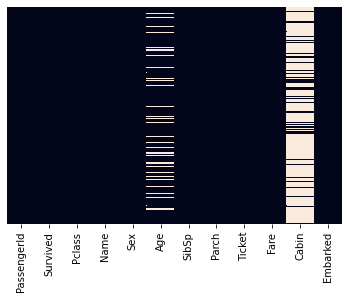

In [11]:
sns.heatmap(titanic_train.isnull(),yticklabels=False,cbar=False,cmap='rocket')

It looks like we have missing data in the 'Age' column and the 'Cabin' column.

In [37]:
titanic_train['Age'].isnull().sum()/891

0.19865319865319866

The calculation above shows that approximately 20% of the age data is missing for the passengers. We can use imputation to replace these null values. The "Cabin" column appears to have too much missing data to do something useful with it at a basic level so this column will be dropped.